In [ ]:
# модуль библиотеки OpenCV для работы с изображениями
import cv2

# всякие полезные библиотеки для работы с матрицами / отрисовки / etc.
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 5)
sns.set_style("white")

from os.path import basename # чтобы достать имя файла из пути


### 1. Подгружаем данные, смотрим на них

In [621]:
pos_size = 81
neg_size = 90 # Будет лучше, если положительных и отрицательных примеров будет поровну
PATH_POS = "/srv/samba/share/data/airbus/train/11/"
# 1 = 81
# 2 = 324
# 3 =4 = 27
# 1+4 = 108
#5 = 152
# 7 = 222
# 8 = 246
# 3+4 = 54
# 3+4c = 216
# 3+4c+add = 415
# 11 = 27

PATH_NEG = "/srv/samba/share/data/airbus/fail/11/"
# 1 = 90
# 2 = 75
# 3 =4 = 30
# 5 = 93, 105
# 6 = 516
# 7 = 207
#8 = 221
# 9 = 240
# 3+4 = 60
# 3+4c = 240
# 3+4c = 442
# 3+4c+add1 = 626
# 11 = 40


PATH_TEST = "/srv/samba/share/data/airbus/test/color/"

In [622]:
def read_faces(path, number):
    """
    Функция для загрузки изображений из папки по пути path.
    """
    names = glob.glob(path + "*.*")
    data = []
    for name in tqdm.tqdm_notebook(names[:number]):
        image = cv2.resize(cv2.imread(name, cv2.IMREAD_GRAYSCALE), (64, 64))
#         data.append(cv2.pyrUp(image[16:48, 16:48]))
        data.append(image)
    return np.array(data)

In [623]:
data_pos = read_faces(path=PATH_POS, number=pos_size) # получим np.array с N_FACES изображениями лиц размера (64, 64)
labels_pos = np.ones(shape=(len(data_pos), 1)) # np.array c единичками 
print("Read %d images, \ndata_pos shape is %s, \nlabels_pos shape is %s" % (pos_size, data_pos.shape, labels_pos.shape))


Read 81 images, 
data_pos shape is (27, 64, 64), 
labels_pos shape is (27, 1)


In [234]:
def show_random_images(data, size = 5):
    """
    Функция для отрисовки size x size случайных изображений из data.
    """
    random_idxs = np.random.randint(0, len(data), size ** 2)
    
    plt.figure(figsize=(12 ,5))
    for i in range(size):
        for j in range(size):
            
            num = i * size + j
            plt.subplot(size, size, num + 1)
            pic = cv2.resize(data[num], (64, 64))
            pic = data[num]
            plt.imshow(pic, cmap='gray')
            plt.axis('off')
    
    plt.show()

In [ ]:
show_random_images(data_pos, size=5)

In [624]:
def read_backgrounds(path, number):
    names = glob.glob(path + "*.*")
    data = []
    for name in tqdm.tqdm_notebook(names[:number]):
        image = cv2.resize(cv2.imread(name, cv2.IMREAD_GRAYSCALE), (64, 64))
#         data.append(cv2.pyrUp(image[16:48, 16:48]))
        data.append(image)
    return np.array(data)

In [625]:
data_neg = read_backgrounds(path=PATH_NEG, number=neg_size)
labels_neg = np.zeros((len(data_neg), 1)) # np.array с нулями
print("Read %d images, \ndata_neg shape is %s, \nlabels_neg shape is %s" % (neg_size, data_neg.shape, labels_neg.shape))


Read 90 images, 
data_neg shape is (40, 64, 64), 
labels_neg shape is (40, 1)


In [ ]:
show_random_images(data_neg)

In [626]:
X = np.concatenate([data_pos, data_neg])
y = np.concatenate([labels_pos, labels_neg])
del data_pos, data_neg, labels_pos, labels_neg

In [627]:
print("Shape of X is %s,\nShape of y is %s" % (X.shape, y.shape))

Shape of X is (67, 64, 64),
Shape of y is (67, 1)


### 2. Пишем функцию для извлечения HOG

In [628]:
def get_hog_vector(grayscale_image):
    """
    Функция, возвращающая вектор HOG для одного grayscale-изображения размера (64 x 64). 
    Возвращаемый вектор имеет вид (1 x длина вектора HOG).
    """
    
    image_resized = cv2.resize(grayscale_image, (64, 64))
 
    hog_descriptor = cv2.HOGDescriptor((64, 64), #winsize
                                       (32, 32), #blocksize
                                       (16, 16), #blockstride
                                       (8, 8),   #cellsize
                                       9)        #nbins

    return hog_descriptor.compute(image_resized).T

In [629]:
vector_hog = get_hog_vector(X[0])
#vector_hog1 = get_hog_vector(X[1])
print(vector_hog.shape)

# Проверка
# assert vector_hog.shape == (1, 96), r"Dimensions mismatch: vector_hog must be of shape (1, 144)"

(1, 1296)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


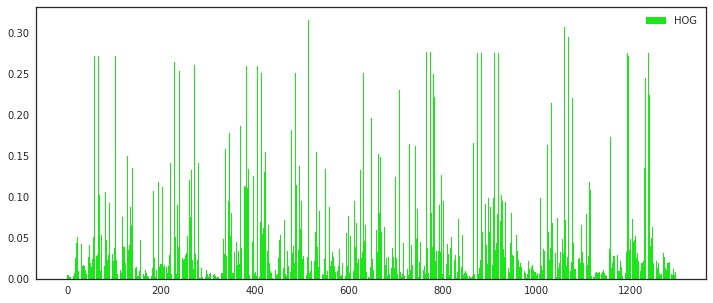

In [630]:
plt.figure(figsize=(12, 5))
plt.bar(range(vector_hog.shape[1]), vector_hog.flatten(), label="HOG", color=[0.1,0.9,0.1]) 
plt.legend()

In [160]:
# plt.figure(figsize=(12, 5))
# plt.hold(True)
# for i in range(5):
#     plt.bar(range(vector_hog.shape[1]), get_hog_vector(X[i] + 10).flatten(), label="HOG", color=[0.45 + 0.05 * i,0.1,0.1])
    
# for i in range(5):
#     plt.bar(range(vector_hog.shape[1]), get_hog_vector(X[i + pos_size + 10]).flatten(), label="HOG", color=[0.1,0.45 + 0.05 * i,0.1])

In [32]:
# plt.figure(figsize=(12, 5))
# plt.hold(True)
# for i in range(5):
# #     plt.plot(xdata = range(vector_hog.shape[1]), ydata = get_hog_vector(X[i] ).flatten(), label="HOG", color=[0.45 + 0.05 * i,0.1,0.1])
#     plt.plot( range(vector_hog.shape[1]),  get_hog_vector(X[i] ).flatten(), color=[0.45 + 0.05 * i,0.1,0.1], marker='.', linestyle='None')
    
# for i in range(5):
#     plt.plot( range(vector_hog.shape[1]),  get_hog_vector(X[i + pos_size ] ).flatten(), color=[0.1,0.45 + 0.05 * i,0.1], marker='.', linestyle='None')


In [633]:
def get_hog_matrix(array_images):
    """
    Функция, возвращающая матрицу, i-я строка которой является вектором HOG для i-го изображения 
    входного массива.
    Возвращаемая матрица имеет вид (число изображений x длина вектора HOG)
    """
    
    # Ваш код здесь
    
#     matrix = np.array([get_hog_vector(image.reshape(128, 128)).flatten() for image in array_images]) 
    matrix = np.array([get_hog_vector(image.reshape(64, 64)).flatten() for image in array_images]) 
    return matrix

In [634]:
X_hog = get_hog_matrix(X)

# Проверка
# assert X_hog.shape == (neg_size + pos_size, 96), r"Dimensions mismatch: data_hog must be of shape (%d, 1296)" % (neg_size + pos_size)

### 3. Обучаем SVM на признаках HOG нашего датасета

In [635]:
# Отмасштабируем наши признаки, чтобы среднее значение и дисперсия каждого из признаков были равны 0 и 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_hog = scaler.fit_transform(X_hog)

In [636]:
# модули для оптимизации моделей машинного обучения
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [637]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.3)

In [638]:
svm = SVC(C=1e-2, kernel='linear', probability=True)
# svm = SVC(C=1e-1, kernel='sigmoid', probability=True)
svm.fit(X_train, y_train.ravel())

# Ваш код здесь (по желанию).

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [639]:
y_pred = svm.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy on test set is % .4f" % accuracy_score(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=5))

Accuracy on test set is  1.0000
             precision    recall  f1-score   support

        0.0    1.00000   1.00000   1.00000        15
        1.0    1.00000   1.00000   1.00000         6

avg / total    1.00000   1.00000   1.00000        21



In [640]:
# Ваш код здесь

info = svm.fit(X_hog, y.ravel())

##  подбор параметров

In [616]:
def plot_validation_curve(param_list, param_name, cv_train_mean, cv_train_std, cv_test_mean, cv_test_std, logscale=False):
    """
    Вспомогательная функция для построения кривых качества на валидации/тесте в зависимости от значений гиперпараметра.
    param_list: список из значений параметра
    param_name: имя для параметра (для отображения на графике)
    cv_train_mean: список из значений метрики качества на обучающей подвыборке для каждого значения параметра
    cv_train_std: СКО для него
    cv_test_mean: список из значений метрики качества на тестовой подвыборке для каждого значения параметра
    cv_test_std: СКО для него
    logscale: ставьте True если параметр меняется в логарифмическом масштабе, по умолчанию False
    """
    cv_train_mean_ar = np.array(cv_train_mean)
    cv_train_std_ar = np.array(cv_train_std)
    cv_test_mean_ar = np.array(cv_test_mean)
    cv_test_std_ar = np.array(cv_test_std)
    
    
    plt.plot(param_list, cv_train_mean, label='CV train score')
    plt.fill_between(param_list, cv_train_mean_ar - cv_train_std_ar, cv_train_mean_ar + cv_train_std_ar, facecolor='blue', alpha=0.3)
    plt.plot(param_list, cv_test_mean, label='CV test score')
    plt.fill_between(param_list, cv_test_mean_ar - cv_test_std_ar, cv_test_mean_ar + cv_test_std_ar, facecolor='green', alpha=0.3)
    
    
#     plt.plot(param_list, test_mean, label='Test score')
    
    plt.title("Validation curve for parameter %s" % param_name)
    plt.legend()
    
    if logscale:
        plt.xscale('log')
    plt.show()

### 4.1. Пишем функцию для реализации метода sliding window

In [641]:
def sliding_window(image, winside=64, step=64):
    """
    Функция-генератор для сканирования изображения окном размера (winside x winside) с шагом step.
    Возвращает 4-кортеж координат окна вида (y1, x1, y2, x2).
    """
    
    for i in range(0, int((image.shape[0] - winside) / step + 1) ):
        for j in range(0, int((image.shape[1] - winside) / step + 1) ):
            yield (i * step, 
                   j * step, 
                   i * step + winside, 
                   j * step + winside)

In [642]:
def fileName(path):
    words = re.split('_',basename(path))[:1]
    return '_'.join(words)+'.jpg'

In [643]:
def check_on_families(scaler, estimator, path, thres=0.95):
    """
    Вспомогательная функция для загрузки и сканирования тестовых изображений и отрисовки найденных лиц на них.
    Изучите работу функции.
    """
    families_list = glob.glob(path + "*.*") # получаем список имен файлов с изображениями
    print(families_list)

    for family in families_list:
        image = cv2.imread(family, cv2.IMREAD_GRAYSCALE)

#  автоматический "Порог" для изображений. Не работет пока
#         image_src = cv2.imread(family, cv2.IMREAD_GRAYSCALE)
#         thr = 200
#         maxv = 255
#         ret,image = cv2.threshold(image_src,thr,maxv,cv2.THRESH_BINARY_INV)
#         image = cv2.blur(image,(25,25))
#         plt.subplot(2,1,1),plt.imshow(image,'gray')
#         image_draw = cv2.cvtColor(image_src, cv2.COLOR_GRAY2RGB) # создаем копию изображения, на которой будем рисовать
        
        image = cv2.pyrDown(image)                    # теперь в image лежит изображение
        i = 0
        face_boxes = []
        for box in sliding_window(image, step=8):
            y1, x1, y2, x2 = box                      # получаем координаты очередного окна (bbox-а)
            bbox = image[y1:y2, x1:x2]                # "вырезаем" из изображения это окно
            hog = get_hog_vector(bbox)                # подаем на вход функции, вычисляющей HOG
            hog_tr = scaler.transform(hog)            # нормируем вектор
            is_face = svm.predict_proba(hog_tr)[0][1] # с помощью модели предсказываем для окна "вероятность быть лицом"
            if is_face > thres: 
                face_boxes.append(box)                # если вероятность выше порога, сохраняем координаты окна
                cv2.imwrite(str(i) + '.jpg', bbox) #пишем окно в файл чтобы потом его hard-negative mining
                i = i+1
        
        image_draw = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # создаем копию изображения, на которой будем рисовать
#         image_colored = cv2.imread("/srv/samba/share/data/airbus/test/color/"+basename(fileName(family)), cv2.IMREAD_COLOR)
        for face_box in face_boxes:
            cv2.rectangle(image_draw, (face_box[1], face_box[0]), (face_box[3], face_box[2]), (0, 255, 0), 1)
#             cv2.rectangle(image_colored, (face_box[1]*2, face_box[0]*2), (face_box[3]*2, face_box[2]*2), (0, 255, 0), 1)

#         plt.imshow(image_draw)                               # отрисовываем результат
#         plt.subplot(2,1,2),plt.imshow(image_draw,'gray')
#         plt.show()
        image_draw = cv2.putText(image_draw,'Image=' + family,(10,35),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        image_draw = cv2.putText(image_draw,'PATH_POS='+PATH_POS,(10,70),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        image_draw = cv2.putText(image_draw,'PATH_NEG='+PATH_NEG,(10,105),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        image_draw = cv2.putText(image_draw,'pos_size='+str(pos_size),(10,140),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        image_draw = cv2.putText(image_draw,'neg_size='+str(neg_size),(10,175),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        image_draw = cv2.putText(image_draw,'svminfo='+repr(info),(10,210),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
        cv2.imwrite(os.path.splitext(basename(family))[0]+'_out.jpg', image_draw)
        
#         image_colored = cv2.putText(image_colored,'Image=' + family,(10,35),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         image_colored = cv2.putText(image_colored,'PATH_POS='+PATH_POS,(10,70),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         image_colored = cv2.putText(image_colored,'PATH_NEG='+PATH_NEG,(10,105),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         image_colored = cv2.putText(image_colored,'pos_size='+str(pos_size),(10,140),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         image_colored = cv2.putText(image_colored,'neg_size='+str(neg_size),(10,175),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         image_colored = cv2.putText(image_colored,'svminfo='+repr(info),(10,210),cv2.FONT_HERSHEY_SIMPLEX,1,(255,15,15))
#         cv2.imwrite(os.path.splitext(basename(family))[0]+'_out_color.jpg', image_colored)

In [645]:
# plt.rcParams['figure.figsize'] = (25, 25)
plt.rcParams['figure.figsize'] = (30, 30)
%time check_on_families(scaler, svm, path=PATH_TEST, thres=0.65)

['/srv/samba/share/data/airbus/test/color1/vko18-gr-small.jpg', '/srv/samba/share/data/airbus/test/color1/svo18-gr1-small1.jpg', '/srv/samba/share/data/airbus/test/color1/jfk18-2km.jpg', '/srv/samba/share/data/airbus/test/color1/dme18-gr1-small.jpg', '/srv/samba/share/data/airbus/test/color1/svo18-gr1-small2.jpg', '/srv/samba/share/data/airbus/test/color1/jto17-gr1-small.jpg']
CPU times: user 1min 25s, sys: 552 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:

plt.rcParams['figure.figsize'] = (25, 10)
thr = 200
maxv = 255
img = cv2.imread('/srv/samba/share/data/airbus/test/small/aero-svo18_gr_small.jpg',cv2.IMREAD_GRAYSCALE) # 0
ret,thresh1 = cv2.threshold(img,thr,maxv,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,thr,maxv,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,thr,maxv,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,thr,maxv,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,thr,maxv,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

##  Аугментация

In [ ]:
from imgaug import augmenters as iaa

In [ ]:
# seq = iaa.Sequential([
#     iaa.Affine(rotate=(-45,90))
# ])

seq = iaa.Sequential([
    iaa.SomeOf((0, 5), iaa.Affine(rotate=(-45,45)) )
])


In [147]:
img = cv2.imread('/srv/samba/share/data/airbus/train/test-aug.jpg',cv2.IMREAD_GRAYSCALE)
# print(img)
# print(img.size)
# print(img.shape)
imgList = np.asarray(img).reshape(128,128,1) # Grayscale images must have shape (height, width, 1) each.
# print(imgList)
# print(imgList.size)
print(imgList.shape)
img_aug = seq.augment_image(imgList)
# print(img_aug)
print(img_aug.shape)
img_aug = np.asarray(img_aug).reshape(128,128)
print(img_aug.shape)

(128, 128, 1)
(128, 128, 1)
(128, 128)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


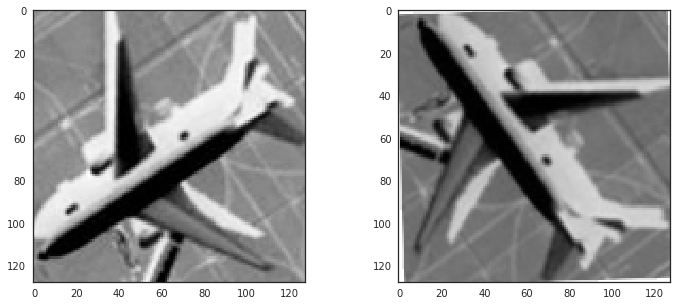

In [148]:
plt.subplot(1,2,1), plt.imshow(img)
plt.subplot(1,2,2), plt.imshow(img_aug)
plt.show()

In [125]:
seq.show_grid(img, cols=8, rows=8)

RuntimeError: Could not execute image viewer.

<built-in method ravel of numpy.ndarray object at 0x7ff33fda1670>


array([153, 159, 160, ..., 161, 150, 140], dtype=uint8)